# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [ ]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2024-04-19 07:36:33--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   116KB/s    in 3m 34s  

2024-04-19 07:40:09 (111 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



#Загрузка необходимых библиотек

In [ ]:
pip install split-folders

In [ ]:
pip install torchinfo

In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=93269745f78ccc64064f60bfc8ed5ff5f3b2f86e4a56d196dc13f90f3cce39dc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import numpy as np
import pandas as pd
import os
import wget
import matplotlib.pyplot as plt
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict
import random
import pathlib
import splitfolders
import torch
import torchvision
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchmetrics import ConfusionMatrix
from sklearn.metrics import classification_report

# Предобработка данных

In [ ]:
SEED = 100
BATCH_SIZE = 64
N_WORKERS = os.cpu_count()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

In [ ]:
path_data ='data/petfaces'

In [ ]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')

    wget.download('http://www.soshnikov.com/permanent/data/petfaces.tar.gz')

    !tar xfz petfaces.tar.gz
    os.remove('petfaces.tar.gz')

    os.chdir('..')

In [ ]:
path_train_test_val = 'data/petfaces_train_test_val'

In [ ]:
if os.path.isdir(path_train_test_val) == False:
    splitfolders.ratio(path_data,
                       output=path_train_test_val,
                       ratio=(.8, .15, .05),
                       group_prefix=None,
                       move=False)

Copying files: 3211 files [00:00, 5374.30 files/s]


In [ ]:
path_train = f'{path_train_test_val}/train'
path_val = f'{path_train_test_val}/val'
path_test = f'{path_train_test_val}/test'

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
def plot_transformed_images(transforms: torchvision.transforms.transforms.Compose,
                            n_images: int,
                            target_dir: str,
                            seed: int = None,
                            depth: str = '*/*/*') -> None:

    font_s = 12
    random.seed(seed)

    image_paths = list(pathlib.Path(target_dir).glob(f'{depth}.jpg'))
    image_random = random.sample(image_paths, k=n_images)

    for image in image_random:
        with Image.open(image) as file:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(file)
            ax[0].set_title(f'Исходный: \n{np.array(file).shape}')
            ax[0].axis('off')
            image_transformed = transforms(file).permute(1, 2, 0)
            ax[1].imshow(image_transformed)
            ax[1].set_title(f'Трансформированный: \n{image_transformed.numpy().shape}')
            ax[1].axis('off')

        fig.suptitle(f'Класс {image.parent.stem}', fontsize=font_s+4)

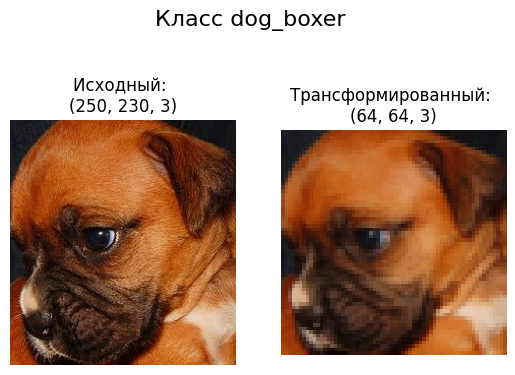

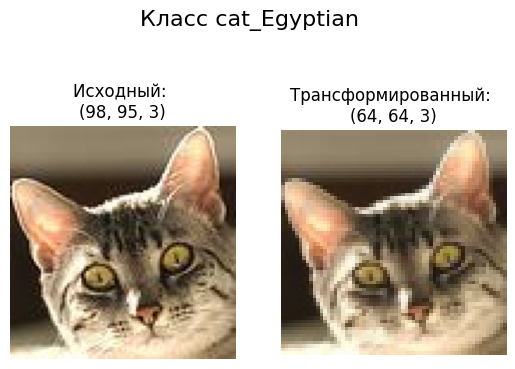

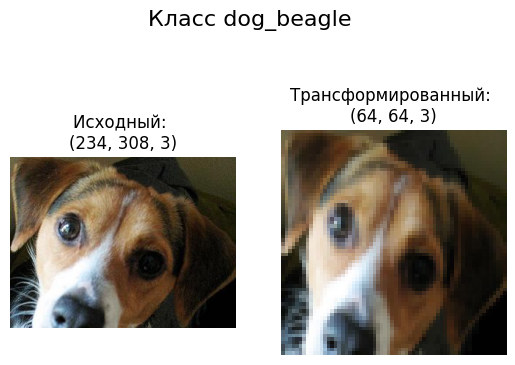

In [ ]:
plot_transformed_images(data_transforms, 3, path_train_test_val)

In [ ]:
def iterate_dataloader(dataloader: torch.utils.data.dataloader.DataLoader,
                       return_iterator: bool = False) -> None or Tuple[torch.Tensor, torch.Tensor]:

    imgs, labels = next(iter(dataloader))

    print(f'Размерность изображения: {imgs.shape} -> [batch_size, color_channels, height, width]')
    print(f'Размерность класса: {labels.shape}')

    if return_iterator:
        return imgs, label

In [ ]:
train_data = datasets.ImageFolder(
    root=path_train,
    transform=data_transforms,
    target_transform=None
)

val_data = datasets.ImageFolder(
    root=path_val,
    transform=data_transforms
)

In [ ]:
class_names = train_data.classes

class_names

['cat_Abyssinian',
 'cat_Bengal',
 'cat_Birman',
 'cat_Bombay',
 'cat_British',
 'cat_Egyptian',
 'cat_Maine',
 'cat_Persian',
 'cat_Ragdoll',
 'cat_Russian',
 'cat_Siamese',
 'cat_Sphynx',
 'dog_american',
 'dog_basset',
 'dog_beagle',
 'dog_boxer',
 'dog_chihuahua',
 'dog_english',
 'dog_german',
 'dog_great',
 'dog_havanese',
 'dog_japanese',
 'dog_keeshond',
 'dog_leonberger',
 'dog_miniature',
 'dog_newfoundland',
 'dog_pomeranian',
 'dog_pug',
 'dog_saint',
 'dog_samoyed',
 'dog_scottish',
 'dog_shiba',
 'dog_staffordshire',
 'dog_wheaten',
 'dog_yorkshire']

In [ ]:
class_dict = train_data.class_to_idx

class_dict

{'cat_Abyssinian': 0,
 'cat_Bengal': 1,
 'cat_Birman': 2,
 'cat_Bombay': 3,
 'cat_British': 4,
 'cat_Egyptian': 5,
 'cat_Maine': 6,
 'cat_Persian': 7,
 'cat_Ragdoll': 8,
 'cat_Russian': 9,
 'cat_Siamese': 10,
 'cat_Sphynx': 11,
 'dog_american': 12,
 'dog_basset': 13,
 'dog_beagle': 14,
 'dog_boxer': 15,
 'dog_chihuahua': 16,
 'dog_english': 17,
 'dog_german': 18,
 'dog_great': 19,
 'dog_havanese': 20,
 'dog_japanese': 21,
 'dog_keeshond': 22,
 'dog_leonberger': 23,
 'dog_miniature': 24,
 'dog_newfoundland': 25,
 'dog_pomeranian': 26,
 'dog_pug': 27,
 'dog_saint': 28,
 'dog_samoyed': 29,
 'dog_scottish': 30,
 'dog_shiba': 31,
 'dog_staffordshire': 32,
 'dog_wheaten': 33,
 'dog_yorkshire': 34}

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)
iterate_dataloader(train_dataloader)

Размерность изображения: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Размерность класса: torch.Size([64])


In [ ]:
def plot_permuted_image(data: torchvision.datasets.folder.ImageFolder,
                        index: int,
                        target_dir: str,
                        depth: str = '*/*/*') -> None:

    font_s = 12
    img, label = data[index][0], data[index][1]

    image_paths = list(pathlib.Path(target_dir).glob(f'{depth}.jpg'))
    image_random = random.choice(image_paths)

    # PyTorch default shape is [C, H, W] but Matplotlib is [H, W, C]
    img_permute = img.permute(1, 2, 0)

    print(f'Исходная размерность: {img.shape} -> [color_channels, height, width]')
    print(f'Изменённая размерность: {img_permute.shape} -> [height, width, color_channels]')

    plt.imshow(img_permute)
    plt.title(data.classes[label], fontsize=font_s+4)

Исходная размерность: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Изменённая размерность: torch.Size([64, 64, 3]) -> [height, width, color_channels]


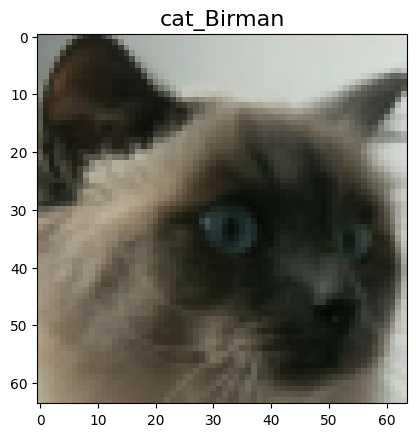

In [ ]:
plot_permuted_image(train_data, 150, path_train_test_val)

#Построение и обучение модели

In [ ]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data = datasets.ImageFolder(
    root=path_train,
    transform=data_transforms
)

val_data = datasets.ImageFolder(
    root=path_val,
    transform=data_transforms
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Текущее устройство: cpu


In [ ]:
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)

In [ ]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=35, bias=True)
  )
)

In [ ]:
def check_time(start: float, end: float, device: torch.device) -> None:
    total_time = end - start
    print(f'\nTotal train time on {device}: {total_time:.3f} seconds')

In [ ]:
def plot_loss_curves(loss: List[float],
                     accuracy: List[float],
                     loss_val: List[float] = None,
                     accuracy_val: List[float] = None) -> None:

    font_s = 12
    titles = ['Loss', 'Accuracy']

    epochs = range(len(loss))
    n_cols = len(titles)

    fig, ax = plt.subplots(1, n_cols, figsize=(16,5))

    for i in range(n_cols):
        key = n_cols * i

        ax[i].plot(epochs, [loss, accuracy][i], label=f'{titles[i].lower()}_train')

        if loss_val is not None and accuracy_val is not None:
            ax[i].plot(epochs, [loss_val, accuracy_val][i], label=f'{titles[i].lower()}_val')

        ax[i].set_title(titles[i], fontsize=font_s+4)
        ax[i].set_xlabel('Epochs', fontsize=font_s)

        ax[i].legend(loc='upper right')
        ax[i].grid()

        i += 1

In [ ]:
class IMGClassifier:

    def __init__(self, model: torch.nn.Module, device: torch.device) -> None:
        self.model = model
        self.device = device


    def train(self,
              dataloader: torch.utils.data.DataLoader,
              n_epochs: int,
              loss_f: torch.nn.Module,
              optimizer: torch.optim.Optimizer = None,
              n_epochs_check: int = 10) -> Tuple[float, float]:

        self.loss_f = loss_f

        self.best_result = {
            'model': self.model.__class__.__name__,
            'loss': 0,
            'accuracy': 0,
        }

        self.loss_acc_hist = []

        # start timer
        start_time = timer()

        for epoch in tqdm(range(n_epochs), 'Training process'):
            # training
            loss, acc, pred = self.predict(dataloader, optimizer)
            self.loss_acc_hist.append([loss, acc])

            if epoch % n_epochs_check == 0 or epoch == n_epochs - 1:
                print(f'Epoch {epoch+1} | Loss: {loss:.4f} | Accuracy: {acc:.4f}')

            if acc > self.best_result['accuracy']:
                self.best_result['loss'] = loss
                self.best_result['accuracy'] = acc
                self.best_result['predictions'] = pred

        # stop timer
        end_time = timer()
        check_time(start_time, end_time, self.device)

        self.loss_acc_hist = np.array(self.loss_acc_hist)

        plot_loss_curves(self.loss_acc_hist[:, 0], self.loss_acc_hist[:, 1])


    def predict(self,
                dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer = None) -> Tuple[float, float]:

        self.model.train()
        loss_total, acc_total = 0, 0
        pred = []

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)

            y_pred = self.model(X)
            loss = self.loss_f(y_pred, y)
            loss_total += loss.item()

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                loss.backward()

            y_pred_probs = torch.softmax(y_pred, dim=1)
            y_pred_class = torch.argmax(y_pred_probs, dim=1)
            acc_total += (y_pred_class == y).sum().item() / len(y_pred)

            pred.extend(y_pred_class)

        loss = loss_total / len(dataloader)
        acc_total = acc_total / len(dataloader)

        return loss_total, acc_total, pred


    def get_top(self, n_top: int) -> pd.DataFrame:
        loss_acc_df = pd.DataFrame(
            self.loss_acc_hist,
            columns=['loss', 'accuracy']
        ).sort_values(by='accuracy', ascending=False)

        top = [loss_acc_df.iloc[0]]

        for i in range(len(loss_acc_df)):
            loss_acc = list(loss_acc_df.iloc[i])

            if loss_acc[1] not in np.array(top)[:, 1]:
                top.append(loss_acc)

            if len(top) == n_top:
                display(pd.DataFrame(np.array(top), columns=['loss', 'accuracy']))
                return

In [ ]:
N_EPOCHS = 50
LEARN_R = 0.001

In [ ]:
model_0_class = IMGClassifier(model_0, device)

Training process:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Loss: 138.3521 | Accuracy: 0.0582
Epoch 11 | Loss: 8.3038 | Accuracy: 0.9421
Epoch 21 | Loss: 0.0801 | Accuracy: 1.0000
Epoch 31 | Loss: 0.0163 | Accuracy: 1.0000
Epoch 41 | Loss: 0.0085 | Accuracy: 1.0000
Epoch 50 | Loss: 0.0054 | Accuracy: 1.0000

Total train time on cpu: 699.886 seconds


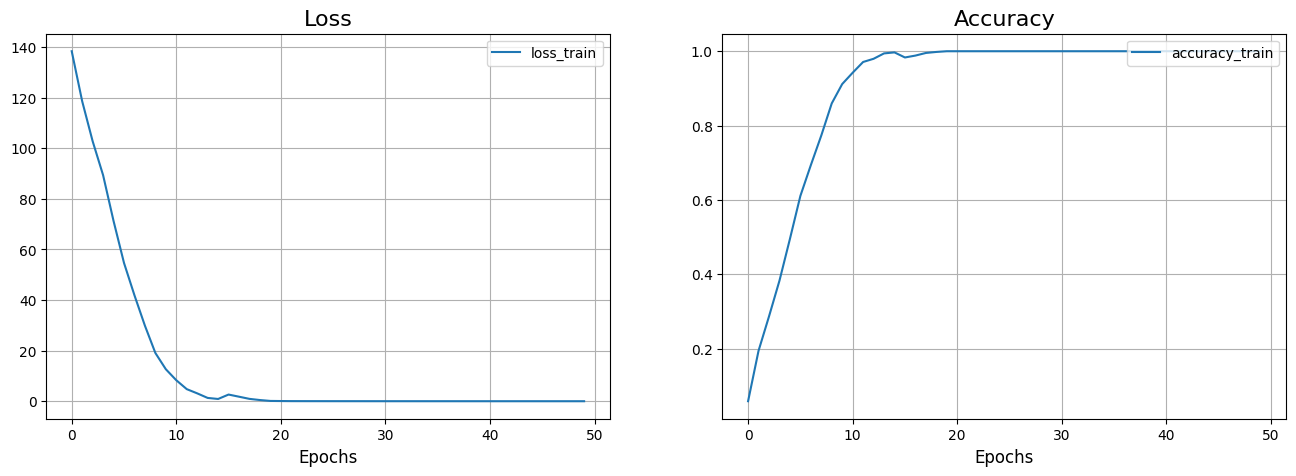

In [ ]:
model_0_class.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader,
    loss_f=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(params=model_0.parameters(), lr=LEARN_R)
)

top-3 accuracy

In [ ]:
model_0_class.get_top(3)

,loss,accuracy
0,0.025820,1.000000
1,0.470772,0.998047
2,0.894484,0.996856


In [ ]:
def filter_df(df: pd.DataFrame,
              value: str) -> pd.DataFrame:

    return pd.DataFrame(
        df.reset_index()[
            df.reset_index()['index'].str.contains(value)
        ].sum(),
        columns=[f'{value}s']
    ).drop('index', axis=0)

In [ ]:
def get_classification_report(targets: list,
                              predictions: list,
                              class_names: list) -> pd.DataFrame:

    return pd.DataFrame(
        classification_report(
            targets,
            predictions,
            target_names=class_names,
            output_dict=True
        )).T.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)

In [ ]:
model_0_class_report = get_classification_report(
    train_data.targets,
    [pred.item() for pred in model_0_class.best_result['predictions']],
    class_names
)

Точность двоичной классификации "кошки против собак" на тестовом датасете

In [ ]:
filter_df(model_0_class_report, 'cat').join(filter_df(model_0_class_report, 'dog'))

,cats,dogs
precision,0.348662,0.64776
recall,0.348662,0.64776
f1-score,0.348662,0.64776
support,881.0,1676.0


Точность классификатора на тестовом датасете

In [ ]:
model_0_class_report = get_classification_report(
    train_data.targets,
    [pred.item() for pred in model_0_class.best_result['predictions']],
    class_names
)
model_0_class_report

,precision,recall,f1-score,support
dog_american,0.071942,0.071942,0.071942,139.000000
dog_newfoundland,0.064103,0.064103,0.064103,78.000000
cat_Siamese,0.062500,0.062500,0.062500,80.000000
dog_english,0.062069,0.062069,0.062069,145.000000
dog_german,0.054545,0.054545,0.054545,55.000000
cat_Russian,0.051948,0.051948,0.051948,77.000000
cat_Egyptian,0.051724,0.051724,0.051724,58.000000
dog_miniature,0.050000,0.050000,0.050000,60.000000
cat_British,0.037500,0.037500,0.037500,80.000000
cat_Sphynx,0.037500,0.037500,0.037500,80.000000


In [ ]:
def display_confusion_matrix(predictions: List[int],
                             data: torch.utils.data.dataloader.DataLoader,
                             class_names: List[str]) -> None:

    confmat = ConfusionMatrix(num_classes=len(data.classes), task='multiclass')
    confmat_tensor = confmat(
        preds=torch.IntTensor(predictions),
        target=torch.IntTensor(data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10,10)
    )

Confusion matrix

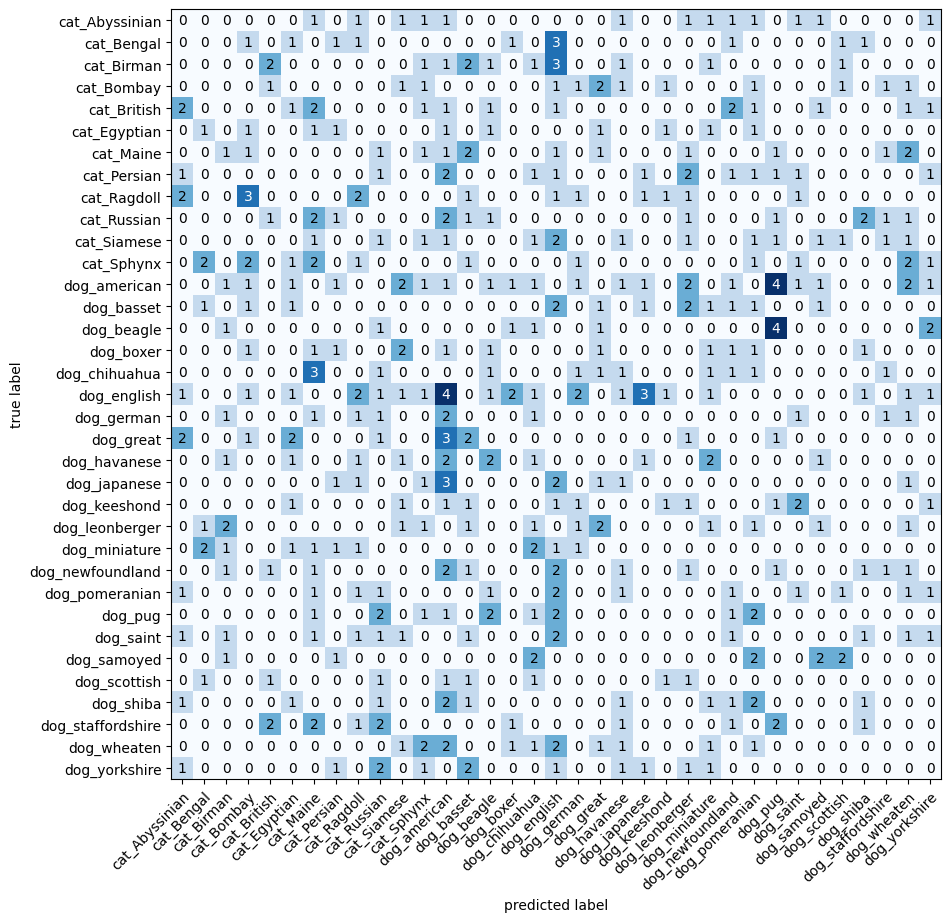

In [ ]:
display_confusion_matrix(
    model_0_class.predict(val_dataloader)[-1],
    val_data,
    class_names
)